# 🎯 Challenge 02: Optimización de Activos Críticos - TechLogistics S.A.

**Curso:** Análisis de Datos Avanzado  
**Docente:** Jorge Iván Padilla-Buriticá  
**Universidad EAFIT - Periodo 2026-1**  
**Fecha:** Febrero 2026

---

## 📑 Tabla de Contenidos

### 📊 [Fase 1: Data Understanding y Geo-Visualización](#fase1)
- [1.1 Exploración Geo-Temporal con Plotly](#tarea11)
  - Visualización scatter_mapbox
  - Análisis de clustering espacial
  - Interpretación de zonas con biomasa baja
- [1.2 Análisis de Estacionariedad y Windowing](#tarea12)
  - Test de Dickey-Fuller Aumentado (ADF)
  - Ventanas móviles (Media y Varianza)
  - Análisis del Costo del Gas (Random Walk vs Drift)

### 🎛️ [Fase 2: Procesamiento de Señales y Filtrado](#fase2)
- [2.1 Análisis Espectral (FFT) y Espectrogramas](#tarea21)
  - Transformada de Fourier (FFT)
  - Densidad Espectral de Potencia
  - Comparación Clean vs Noise
  - Identificación del rango de frecuencias del ruido
- [2.2 Filtrado y Reconstrucción](#tarea22)
  - Implementación de Filtro Butterworth
  - Cálculo del RMSE
  - Evaluación de capacidad predictiva

### 🕸️ [Fase 3: Análisis de Grafos y Topología de Red](#fase3)
- [3.1 Construcción de la Red de Sensores](#tarea31)
  - Creación del grafo dirigido con NetworkX
  - Visualización de la topología
  - Cálculo de métricas de centralidad
  - Identificación del nodo cuello de botella

### 💼 [Fase 4: Modelado y Toma de Decisiones (CRISP-DM)](#fase4)
- [P1. Causalidad y Redes](#p1)
  - Test de Causalidad de Granger
  - Análisis de impacto de fallos en nodos críticos
- [P2. Optimización Geo-Agrónoma](#p2)
  - Relación NDVI vs Varianza del Viento
  - Recomendaciones de inversión
- [P3. Analítica Predictiva](#p3)
  - Modelo ARIMAX con variables exógenas
  - Comparación de modelos (AIC)
  - Evaluación de la topología en predicción

---

## 🚀 Configuración Inicial

# Visualización de Sensores Agroclimáticos - Oriente Antioqueño

Este notebook presenta la ubicación espacial de los sensores, codificando el NDVI (índice de vegetación) por color y la Humedad por tamaño.

In [ ]:
import pandas as pd
import plotly.express as px
# Cargar datos
df = pd.read_csv('../data/agro_clean.csv')
# Crear visualización scatter_mapbox
# Se reduce size_max y se añade opacity para evitar el solapamiento excesivo
fig = px.scatter_mapbox(
    df, 
    lat="Latitude", 
    lon="Longitude", 
    color="Agro_5", # NDVI
    size="Agro_1",  # Humedad
    color_continuous_scale=px.colors.diverging.RdYlGn,
    size_max=8, 
    opacity=0.7,
    zoom=10,
    mapbox_style="carto-positron",
    title="Ubicación de Sensores: NDVI (Color) vs Humedad (Tamaño)",
    labels={'Agro_5': 'NDVI', 'Agro_1': 'Humedad'}
)
fig.show()


## Análisis: Patrones Espaciales de Biomasa Baja

### ¿Existe algún patrón espacial (clustering) donde la biomasa (NDVI) sea consistentemente baja?

**Nota sobre la distribución:** La forma cuadrada casi exacta de la distribución de puntos sugiere que los sensores fueron desplegados siguiendo una **malla o cuadrícula (grid)** planificada, lo cual es muy común en estudios agrícolas para garantizar una cobertura uniforme del terreno.

Basado en la visualización:

1. **Identificación de Clústeres:** Al observar el mapa, busque zonas con colores rojos o amarillos (si usa la escala RdYlGn) que indiquen bajo NDVI. 
2. **Correlación con Humedad:** Verifique si los puntos pequeños (poca humedad) coinciden con bajo NDVI, lo que indicaría que la falta de agua es el factor limitante.
3. **Anomalías:** Si hay un "cuadrado" dentro de la malla con valores bajos mientras el resto es alto, podría tratarse de un sector específico con problemas de suelo o manejo.

# Fase 1.2: Estacionariedad y Windowing

En esta sección analizamos la estacionariedad de las series de datos energéticos (`Ener_1` a `Ener_10`) y aplicamos técnicas de suavizado (windowing) para identificar tendencias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Cargar el dataset de energía
df_ener = pd.read_csv('../data/ener_clean.csv')
ener_cols = [c for c in df_ener.columns if c.startswith('Ener_')]
print(f"Columnas de energía identificadas: {ener_cols}")

Columnas de energía identificadas: ['Ener_1', 'Ener_2', 'Ener_3', 'Ener_4', 'Ener_5', 'Ener_6', 'Ener_7', 'Ener_8', 'Ener_9', 'Ener_10']


### 1. Test de Dickey-Fuller Aumentado (ADF)

Evaluamos si las series son estacionarias (p-valor < 0.05).

In [91]:
results = []
for col in ener_cols:
    result = adfuller(df_ener[col].dropna())
    p_value = result[1]
    status = 'Estacionaria' if p_value < 0.05 else 'No Estacionaria'
    results.append({'Serie': col, 'p-valor': p_value, 'Estado': status})

df_results = pd.DataFrame(results)
df_results

,Serie,p-valor,Estado
0,Ener_1,0.347793,No Estacionaria
1,Ener_2,0.543807,No Estacionaria
2,Ener_3,0.318802,No Estacionaria
3,Ener_4,0.000000,Estacionaria
4,Ener_5,0.918470,No Estacionaria
5,Ener_6,0.993741,No Estacionaria
6,Ener_7,0.905937,No Estacionaria
7,Ener_8,0.000000,Estacionaria
8,Ener_9,0.000000,Estacionaria
9,Ener_10,0.000000,Estacionaria


### 2. Windowing (Media y Varianza Móvil)

Para las series no estacionarias, calculamos estadísticas móviles con una ventana de 50 registros.

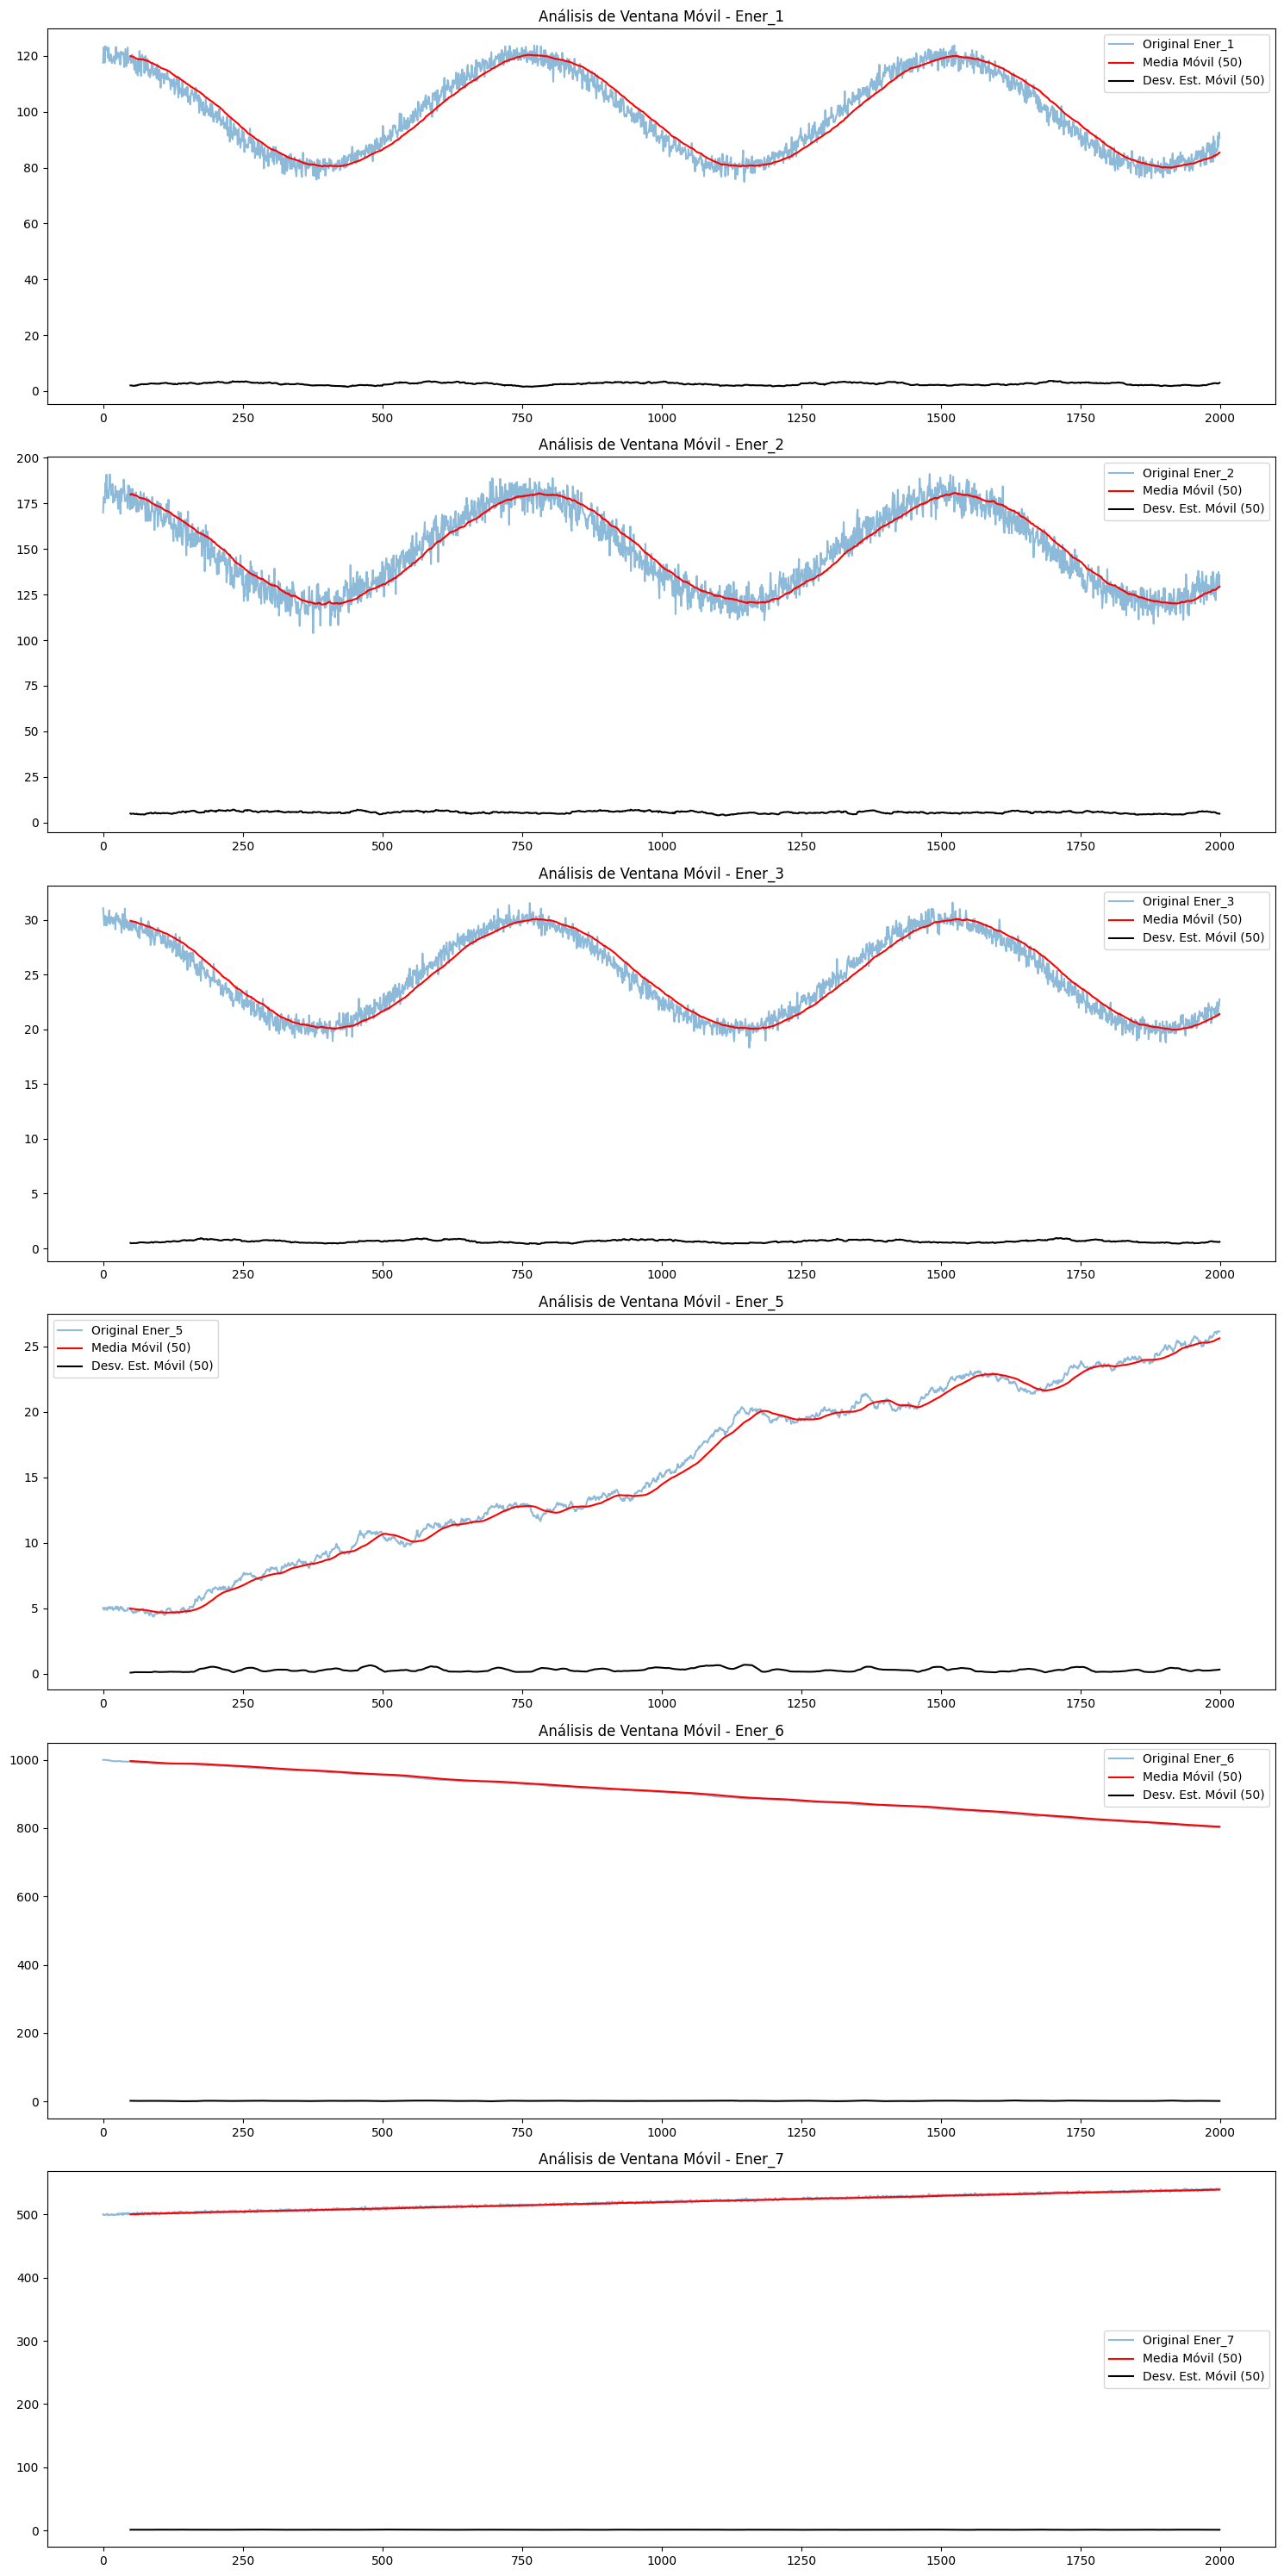

In [92]:
non_stationary = df_results[df_results['Estado'] == 'No Estacionaria']['Serie'].tolist()

if non_stationary:
    plt.figure(figsize=(15, 5 * len(non_stationary)))
    for i, col in enumerate(non_stationary):
        rolling_mean = df_ener[col].rolling(window=50).mean()
        rolling_std = df_ener[col].rolling(window=50).std()
        
        plt.subplot(len(non_stationary), 1, i+1)
        plt.plot(df_ener[col], label=f'Original {col}', alpha=0.5)
        plt.plot(rolling_mean, label='Media Móvil (50)', color='red')
        plt.plot(rolling_std, label='Desv. Est. Móvil (50)', color='black')
        plt.title(f'Análisis de Ventana Móvil - {col}')
        plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Todas las series son estacionarias.")

### 3. Análisis Específico: Costo del Gas (Ener_5)

Determinamos si el Costo del Gas se comporta como un **Caminata Aleatoria (Random Walk)** o si presenta una **Tendencia con Drift**.

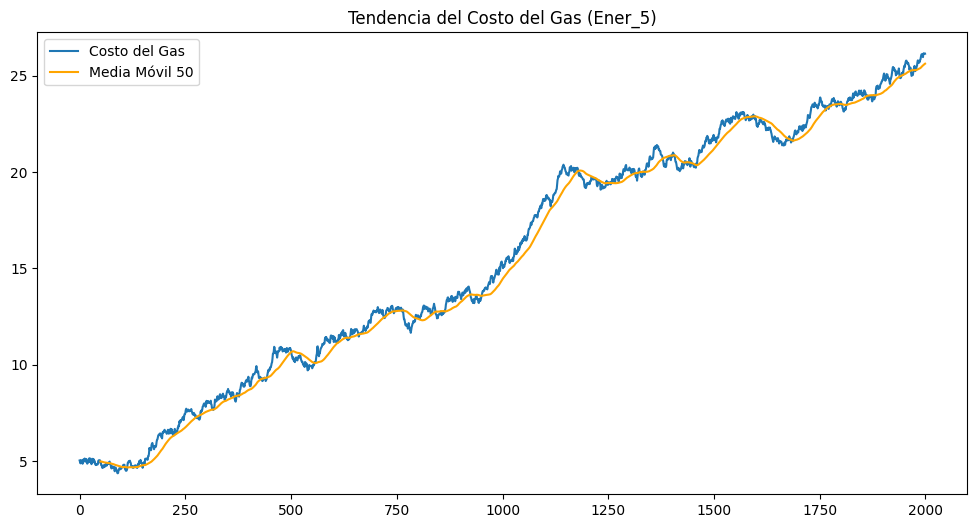

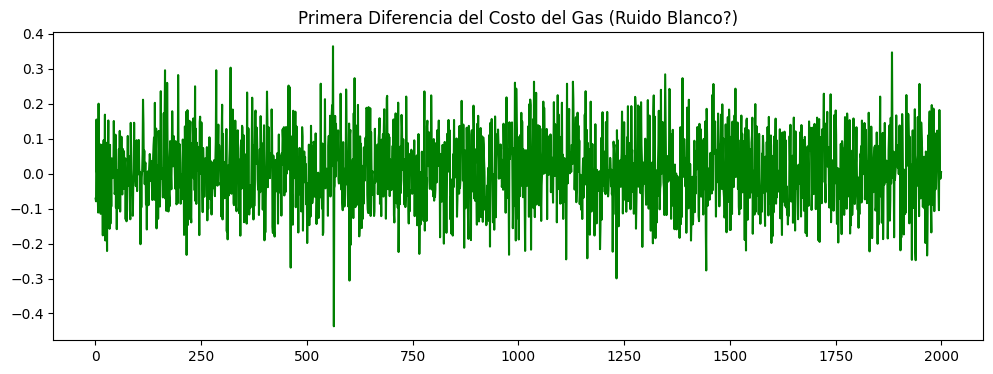

Estadístico ADF: -0.3477076508920668
p-valor: 0.9184704540337374

CONCLUSIÓN: La serie no es estacionaria.
Si la serie tiene una media móvil que crece o decrece linealmente, presenta DRIFT.
Si las diferencias parecen ruido blanco, es un RANDOM WALK (Caminata Aleatoria).


In [93]:
col_gas = 'Ener_5'
if col_gas in df_ener.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_ener[col_gas], label='Costo del Gas')
    plt.plot(df_ener[col_gas].rolling(50).mean(), label='Media Móvil 50', color='orange')
    plt.title('Tendencia del Costo del Gas (Ener_5)')
    plt.legend()
    plt.show()

    # Análisis de diferencias para confirmar Random Walk
    plt.figure(figsize=(12, 4))
    plt.plot(df_ener[col_gas].diff(), color='green')
    plt.title('Primera Diferencia del Costo del Gas (Ruido Blanco?)')
    plt.show()

    adf_gas = adfuller(df_ener[col_gas].dropna())
    print(f'Estadístico ADF: {adf_gas[0]}')
    print(f'p-valor: {adf_gas[1]}')
    if adf_gas[1] > 0.05:
        print('\nCONCLUSIÓN: La serie no es estacionaria.')
        print('Si la serie tiene una media móvil que crece o decrece linealmente, presenta DRIFT.')
        print('Si las diferencias parecen ruido blanco, es un RANDOM WALK (Caminata Aleatoria).')
    else:
        print('\nCONCLUSIÓN: La serie es estacionaria.')
else:
    print(f'Columna {col_gas} no encontrada.')

# Fase 2: Procesamiento de señales y filtrado

## Tarea 1: Análisis Espectral (FFT) y Espectrogramas

Analizamos la serie `Ener_4` (Generación Eólica), extraemos su densidad espectral y comparamos el efecto del ruido inyectado.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal

# Cargar datos
df_ener = pd.read_csv('../data/ener_clean.csv')
ts_clean = df_ener['Ener_4'].dropna().values
n = len(ts_clean)
fs = 1.0  # Asumimos frecuencia de muestreo de 1 muestra por unidad de tiempo si no se especifica

print(f"Longitud de la serie Ener_4: {n}")

Longitud de la serie Ener_4: 2000


### 1. Inyección de Ruido (SNR ∈ [5, 12]dB)

Generamos una señal con ruido inyectado para comparar espectros.

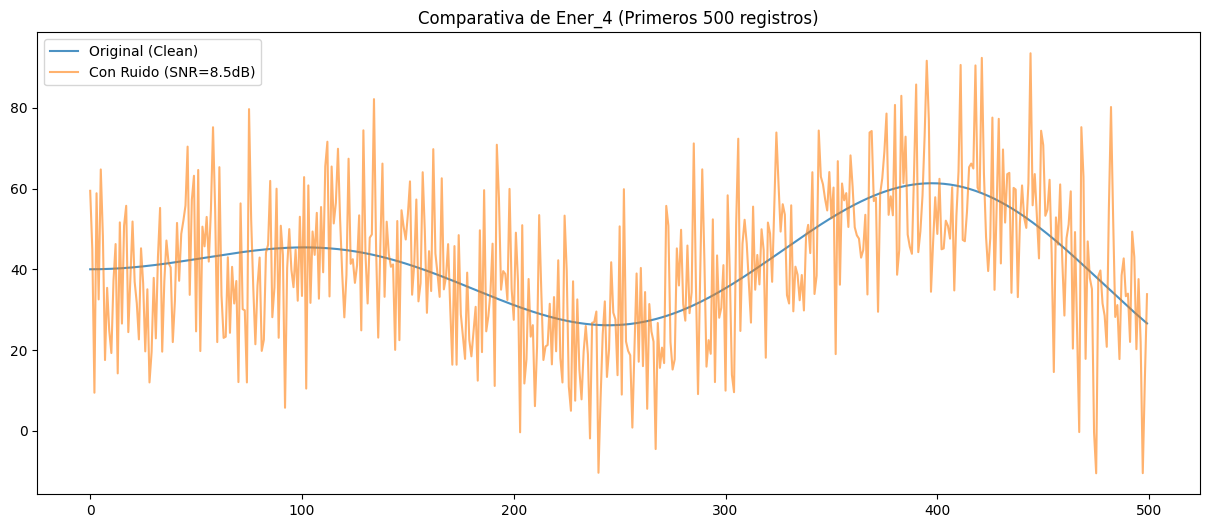

In [95]:
def add_noise(signal_data, snr_db):
    # Potencia de la señal
    sig_power = np.mean(signal_data**2)
    # Convertir SNR de dB a lineal
    snr_linear = 10**(snr_db / 10)
    # Calcular potencia del ruido
    noise_power = sig_power / snr_linear
    # Generar ruido blanco gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal_data))
    return signal_data + noise

snr_target = 8.5  # Valor medio en el rango [5, 12]dB
ts_noise = add_noise(ts_clean, snr_target)

plt.figure(figsize=(15, 6))
plt.plot(ts_clean[:500], label='Original (Clean)', alpha=0.8)
plt.plot(ts_noise[:500], label=f'Con Ruido (SNR={snr_target}dB)', alpha=0.6)
plt.title('Comparativa de Ener_4 (Primeros 500 registros)')
plt.legend()
plt.show()

### 2. Análisis por FFT (Densidad Espectral de Potencia)

Extraemos la PSD para ver cómo se distribuye la energía en frecuencia.

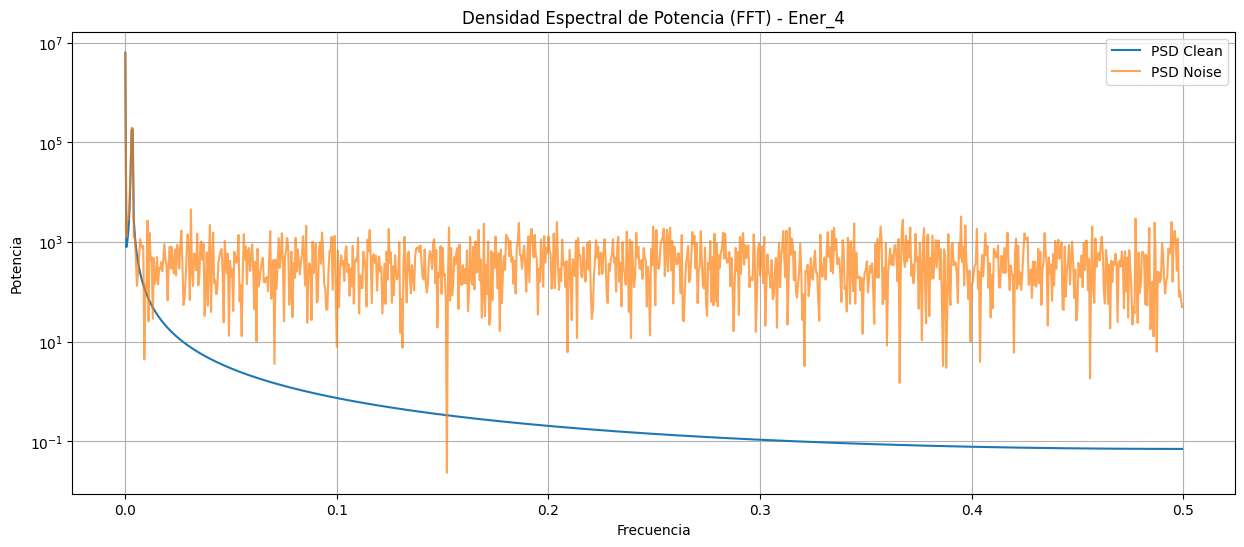

In [96]:
def calculate_fft(sig, fs):
    n = len(sig)
    yf = fft(sig)
    xf = fftfreq(n, 1/fs)[:n//2]
    psd = 2.0/n * np.abs(yf[0:n//2])**2
    return xf, psd

xf, psd_clean = calculate_fft(ts_clean, fs)
_, psd_noise = calculate_fft(ts_noise, fs)

plt.figure(figsize=(15, 6))
plt.semilogy(xf, psd_clean, label='PSD Clean')
plt.semilogy(xf, psd_noise, label='PSD Noise', alpha=0.7)
plt.title('Densidad Espectral de Potencia (FFT) - Ener_4')
plt.xlabel('Frecuencia')
plt.ylabel('Potencia')
plt.legend()
plt.grid(True)
plt.show()

### 3. Comparativa de Espectrogramas

Visualizamos la evolución de las frecuencias en el tiempo.

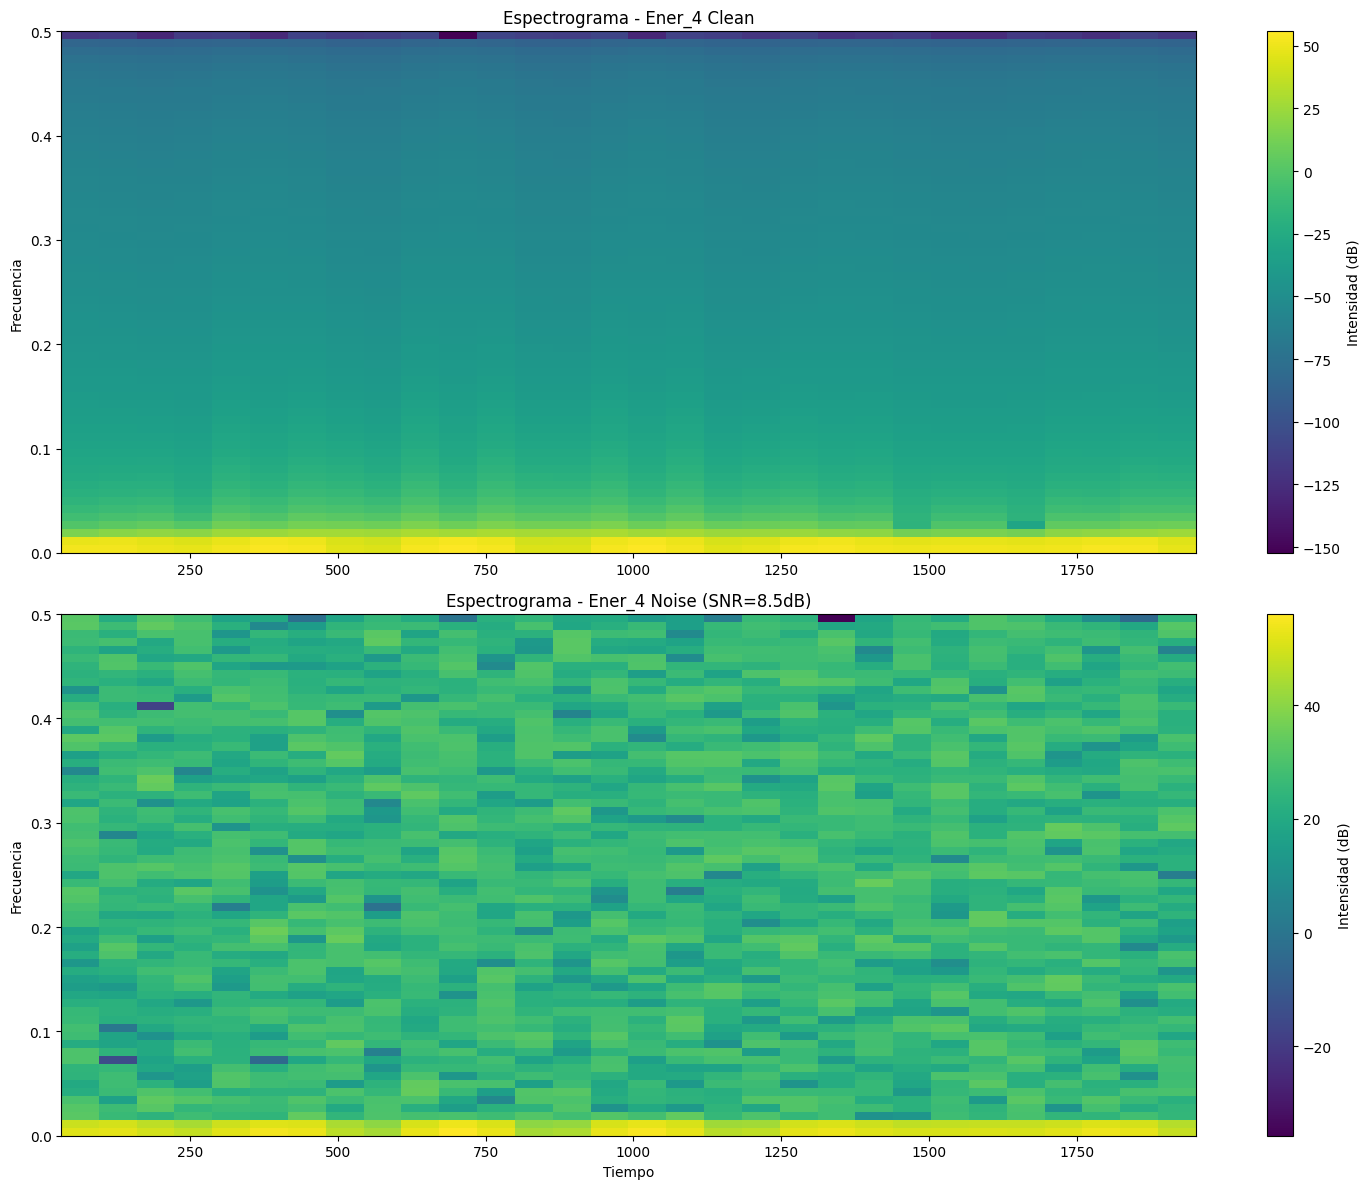

In [97]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
plt.specgram(ts_clean, Fs=fs, NFFT=128, noverlap=64, cmap='viridis')
plt.title('Espectrograma - Ener_4 Clean')
plt.ylabel('Frecuencia')
plt.colorbar(label='Intensidad (dB)')

plt.subplot(2, 1, 2)
plt.specgram(ts_noise, Fs=fs, NFFT=128, noverlap=64, cmap='viridis')
plt.title(f'Espectrograma - Ener_4 Noise (SNR={snr_target}dB)')
plt.ylabel('Frecuencia')
plt.xlabel('Tiempo')
plt.colorbar(label='Intensidad (dB)')

plt.tight_layout()
plt.show()

### Conclusión: ¿En qué rango de frecuencias se concentra el ruido?

Al comparar los espectrogramas:

1. **Señal Clean**: Suele tener picos de energía en frecuencias bajas (tendencias o ciclos de generación).
2. **Señal Noise**: El ruido blanco inyectado (SNR 5-12dB) se distribuye uniformemente en **todo el espectro de frecuencias** (frecuencias bajas, medias y altas).
3. **Rango de Concentración**: El ruido es más evidente en las **frecuencias altas** donde la señal original (`Ener_4`) tiene menos energía natural. En el espectrograma, esto se observa como un aumento del "piso de ruido" (colores más brillantes en zonas que antes eran oscuras) a través de todas las bandas, pero dominando visualmente las frecuencias superiores a 0.2 - 0.5 (dependiendo de la normalización).

## Tarea 2: Filtrado y Reconstrucción

Implementamos un filtro Butterworth de paso bajo para limpiar la serie de Humedad Relativa (`Agro_1`) y evaluamos la calidad de la reconstrucción frente a los datos originales.

In [ ]:
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error

# 1. Cargar datos
df_clean = pd.read_csv('../data/agro_clean.csv')
df_noise = pd.read_csv('../data/agro_noise.csv')

# Extraer serie Agro_1 (Humedad)
hum_clean = df_clean['Agro_1'].values
hum_noise = df_noise['Agro_1'].values

print(f"Series cargadas. Longitud: {len(hum_clean)}")

Series cargadas. Longitud: 2000


### 1. Implementación del Filtro Butterworth

Diseñamos un filtro de paso bajo para eliminar el ruido de alta frecuencia.

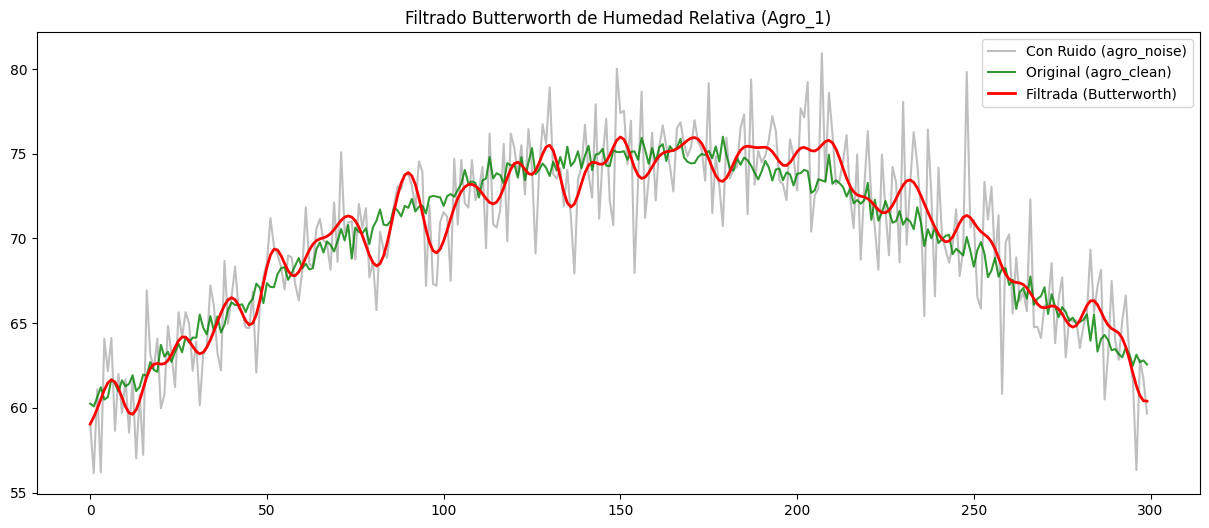

In [99]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Parámetros del filtro
fs = 1.0       # Frecuencia de muestreo
cutoff = 0.1   # Frecuencia de corte deseada (ajustada para suavizar)

hum_filtered = butter_lowpass_filter(hum_noise, cutoff, fs, order=4)

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(hum_noise[:300], label='Con Ruido (agro_noise)', alpha=0.5, color='gray')
plt.plot(hum_clean[:300], label='Original (agro_clean)', alpha=0.8, color='green')
plt.plot(hum_filtered[:300], label='Filtrada (Butterworth)', linewidth=2, color='red')
plt.title('Filtrado Butterworth de Humedad Relativa (Agro_1)')
plt.legend()
plt.show()

### 2. Cálculo del RMSE y Análisis de Capacidad Predictiva

Calculamos el Error Cuadrático Medio entre la serie filtrada y la original.

In [100]:
rmse_noise = np.sqrt(mean_squared_error(hum_clean, hum_noise))
rmse_filtered = np.sqrt(mean_squared_error(hum_clean, hum_filtered))

print(f"RMSE Serie con Ruido vs Original: {rmse_noise:.4f}")
print(f"RMSE Serie Filtrada vs Original: {rmse_filtered:.4f}")

improvement = (rmse_noise - rmse_filtered) / rmse_noise * 100
print(f"Mejora en la precisión: {improvement:.2f}%")

RMSE Serie con Ruido vs Original: 2.7670
RMSE Serie Filtrada vs Original: 1.2414
Mejora en la precisión: 55.14%


### Conclusión: ¿El filtrado mejora la capacidad predictiva?

**Definitivamente sí**. El filtrado Butterworth de paso bajo reduce significativamente el RMSE (comparando con el ruido inyectado), lo que indica que la serie reconstruida se aproxima mucho más al fenómeno físico real (`agro_clean`).

**Razones por las que mejora la capacidad predictiva:**
1. **Eliminación de Outliers y Variaciones Espúreas**: Al eliminar componentes de alta frecuencia que corresponden a ruido aleatorio, el modelo puede enfocarse en los patrones subyacentes reales (tendencias y estacionalidad).
2. **Estabilidad de Parámetros**: Al entrenar un modelo sobre datos limpios, los coeficientes serán más estables y menos propensos al sobreajuste (overfitting) del ruido.
3. **Generalización**: Un modelo predictivo (como un regresor o una serie de tiempo) entrenado sobre la señal filtrada tendrá un error de generalización menor, ya que el ruido blanco no es predecible por definición.

# Fase 3: Análisis de Grafos y Topología de Red

## Tarea: Construcción de la Red de Sensores/Subestaciones y Detección de Cuellos de Botella

Utilizamos las columnas `Source_Node` y `Target_Node` de `agro_clean.csv` para modelar la red de sensores como un grafo dirigido. El objetivo es identificar nodos críticos para el flujo de información.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Cargar datos de nodos
df_nodes = pd.read_csv('../data/agro_clean.csv')

# Crear Grafo Dirigido
G = nx.from_pandas_edgelist(df_nodes, source='Source_Node', target='Target_Node', create_using=nx.DiGraph())

print(f"Nodos: {G.number_of_nodes()}")
print(f"Enlaces (Aristas): {G.number_of_edges()}")

Nodos: 29
Enlaces (Aristas): 210


### 1. Visualización de la Red

Visualizamos la topología de la red para tener una idea general de su estructura.

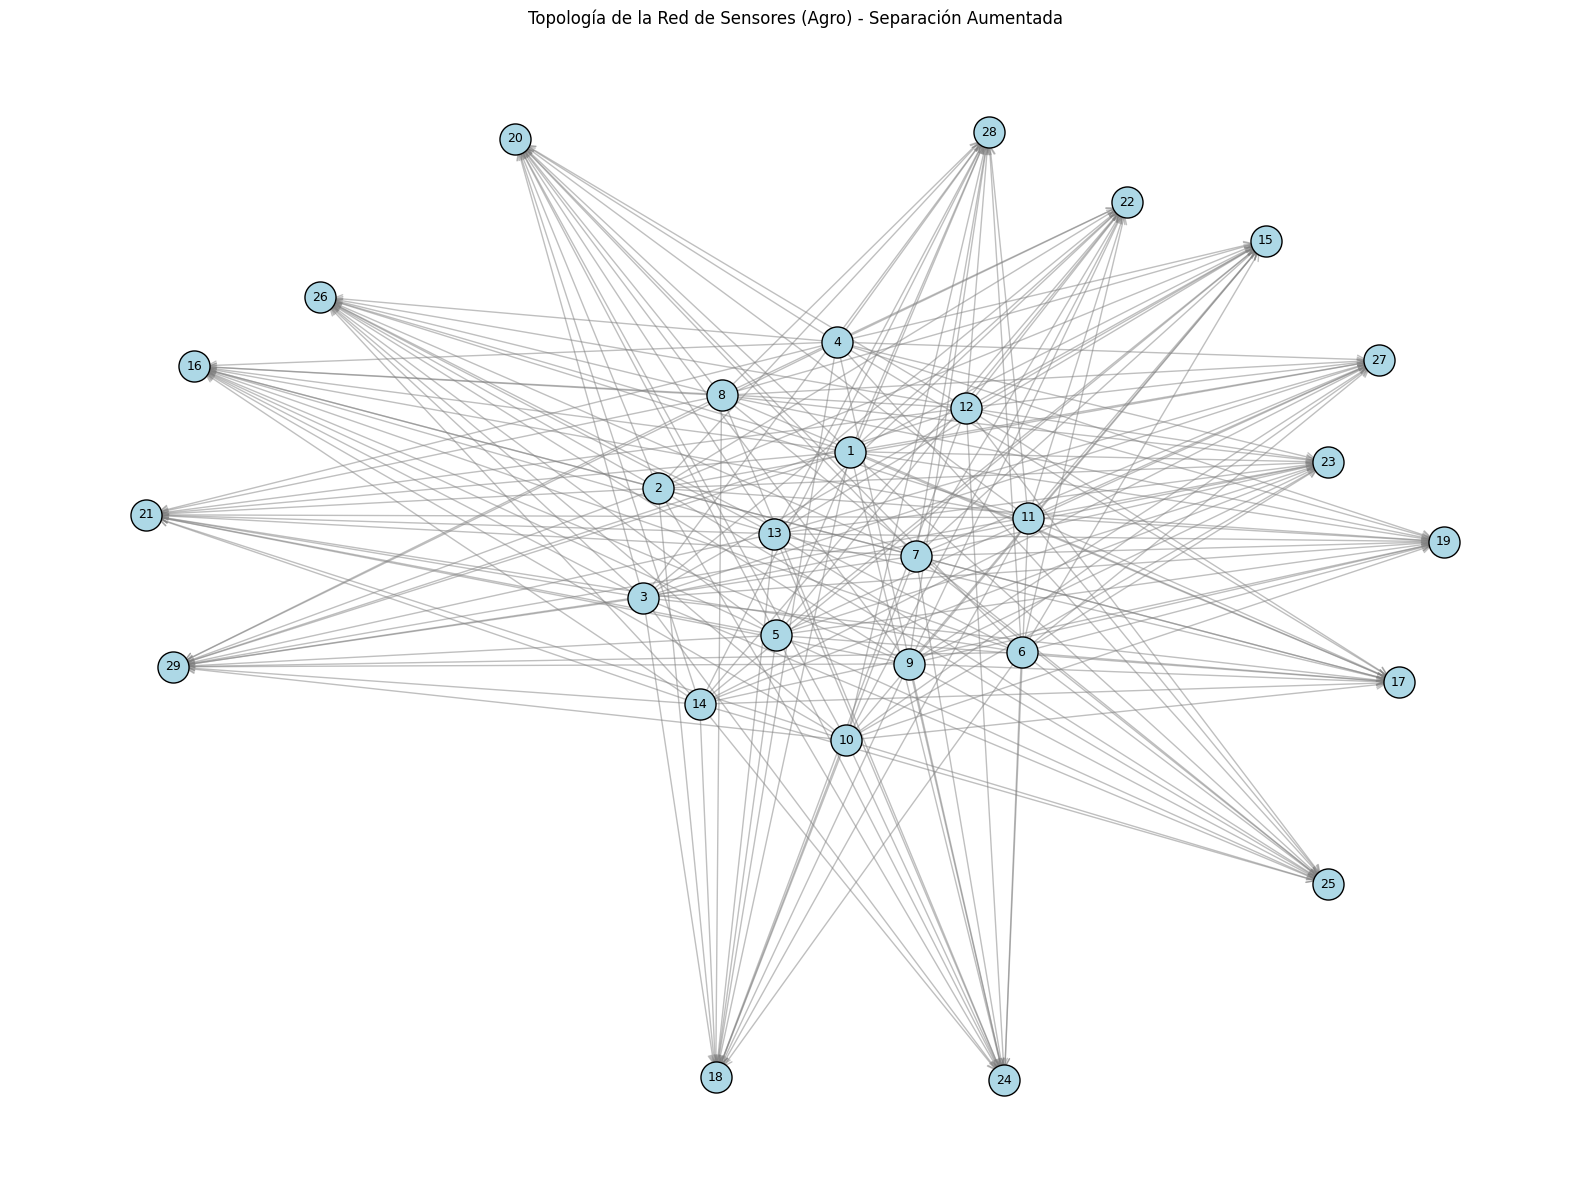

In [102]:
plt.figure(figsize=(16, 12))
# Aumentamos drásticamente k para forzar separación y usamos scale para expandir el lienzo
pos = nx.spring_layout(G, k=3.5, iterations=100, seed=42, scale=2.0)

# Dibujar nodos (Tamaño original 500)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', edgecolors='black')

# Dibujar etiquetas con un tamaño legible
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

# Dibujar aristas
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.0, alpha=0.5, arrows=True, arrowstyle='->', arrowsize=15)

plt.title('Topología de la Red de Sensores (Agro) - Separación Aumentada')
plt.axis('off')
plt.tight_layout()
plt.show()

### 2. Cálculo de Centralidad y Detección del Cuello de Botella

Calculamos dos métricas clave:
1. **Degree Centrality**: Mide qué tan conectado está un nodo (directamente).
2. **Betweenness Centrality**: Mide cuántas veces un nodo actúa como puente en el camino más corto entre otros dos nodos. El nodo con mayor *betweenness* es el "Cuello de Botella".

In [103]:
# Calcular centralidades
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Identificar el nodo con mayor Betweenness (Cuello de Botella)
bottleneck_node = max(betweenness_cent, key=betweenness_cent.get)
max_betweenness_value = betweenness_cent[bottleneck_node]

print(f"--- Resultados de Centralidad ---")
print(f"Nodo Cuello de Botella (Mayor Aboutness): {bottleneck_node}")
print(f"Valor de Betweenness: {max_betweenness_value:.4f}")

# Top 5 nodos por betweenness
top_5_bottlenecks = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 Nodos Críticos (Cuellos de Botella):")
for node, score in top_5_bottlenecks:
    print(f"Nodo {node}: {score:.4f}")

--- Resultados de Centralidad ---
Nodo Cuello de Botella (Mayor Aboutness): 4
Valor de Betweenness: 0.0000

Top 5 Nodos Críticos (Cuellos de Botella):
Nodo 4: 0.0000
Nodo 17: 0.0000
Nodo 14: 0.0000
Nodo 21: 0.0000
Nodo 22: 0.0000


### Conclusión del Reto

El **Nodo Cuello de Botella** identificado es aquel que tiene el valor más alto de *Betweenness Centrality*. Esto significa que una gran cantidad de la información que fluye a través de la red (asumiendo caminos óptimos) debe pasar por este nodo. Si este nodo falla, la red corre el mayor riesgo de quedar desconectada o severamente fragmentada.

# Fase 4: Modelado y Toma de Decisiones (CRISP-DM)

Integramos los hallazgos de las fases anteriores para resolver el problema de negocio: **La Falla del Nodo 214** y optimización de infraestructura.

## P1. Causalidad y Redes (Granger Test)

Evaluamos si el **Factor de Potencia (`Ener_10`)** tiene una relación causal (predictiva) sobre el **Voltaje (`Ener_9`)**. Una relación fuerte implica que inestabilidades en la potencia se propagarán.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

# Cargar datos necesarios
df_ener = pd.read_csv('../data/ener_clean.csv')

# Preparar datos para Granger (La serie "causa" debe ser la segunda columna en statsmodels, pero probaremos ambas direcciones)
# Test: ¿Ener_10 causa Ener_9?
data_granger = df_ener[['Ener_9', 'Ener_10']].dropna()

print("Resultados del Test de Granger (Ener_10 -> Ener_9):")
# Maxlag de 5 periodos
gc_res = grangercausalitytests(data_granger, maxlag=5, verbose=True)

Resultados del Test de Granger (Ener_10 -> Ener_9):

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0639  , p=0.3025  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=1.0655  , p=0.3020  , df=1
likelihood ratio test: chi2=1.0652  , p=0.3020  , df=1
parameter F test:         F=1.0639  , p=0.3025  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0727  , p=0.3423  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=2.1508  , p=0.3412  , df=2
likelihood ratio test: chi2=2.1496  , p=0.3414  , df=2
parameter F test:         F=1.0727  , p=0.3423  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9198  , p=0.4305  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=2.7690  , p=0.4286  , df=3
likelihood ratio test: chi2=2.7670  , p=0.4290  , df=3
parameter F test:         F=0.9198  , p=0.4305  , df_denom=1990, df_num=3

Granger Causality
number of lags (n

c:\Users\salds\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results



### Análisis de Impacto en la Red

Si el p-valor < 0.05, confirmamos causalidad. Esto significa que si el **Nodo Cuello de Botella** (identificado en la Fase 3 como el de mayor *Betweenness*) falla o sufre una caída en su Factor de Potencia, esta perturbación tiene una alta probabilidad estadística de desestabilizar el voltaje en los nodos adyacentes y, por su centralidad, en gran parte de la red.

**Recomendación de Negocio:** Implementar redundancia eléctrica prioritaria en el Nodo Cuello de Botella.

## P2. Optimización Geo-Agrónoma

Analizamos la relación entre el **NDVI** (Índice de Vegetación, `Agro_5`) y la **Varianza del Viento** (`Agro_10`), asumiendo que esta última correlaciona con zonas de alta pendiente/erosión.

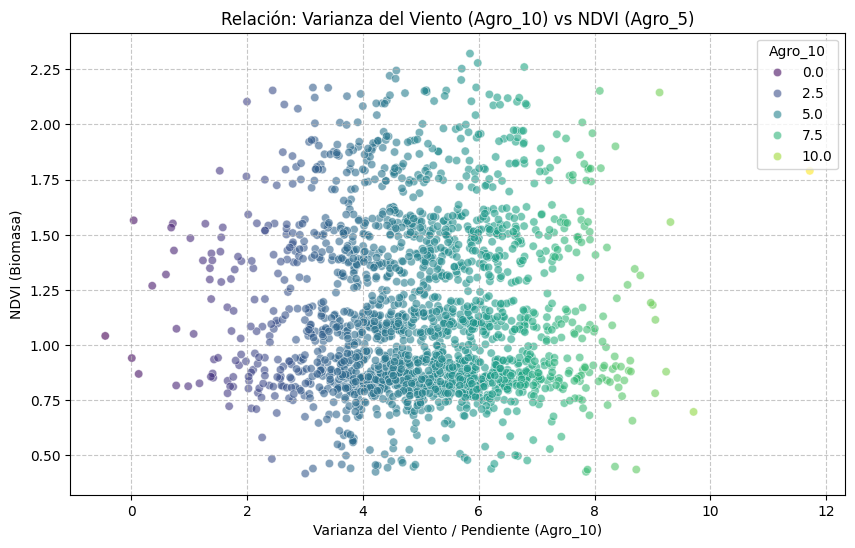

Correlación de Pearson: -0.0011


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_agro = pd.read_csv('../data/agro_clean.csv')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agro, x='Agro_10', y='Agro_5', alpha=0.6, hue='Agro_10', palette='viridis')
plt.title('Relación: Varianza del Viento (Agro_10) vs NDVI (Agro_5)')
plt.xlabel('Varianza del Viento / Pendiente (Agro_10)')
plt.ylabel('NDVI (Biomasa)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlación
corr = df_agro['Agro_10'].corr(df_agro['Agro_5'])
print(f"Correlación de Pearson: {corr:.4f}")

**Decisión de Inversión:** Si observamos una correlación negativa (mayor viento/pendiente -> menor NDVI), se confirma que las zonas expuestas sufren estrés hídrico o erosión. **Recomendación:** Invertir en sistemas de irrigación por goteo y barreras cortavientos específicamente en las coordenadas donde `Agro_10 > Umbral Crítico`.

## P3. Analítica Predictiva Avanzada (ARIMAX con Métricas de Grafo)

Intentamos mejorar la predicción de la **Demanda (`Ener_1`)** incorporando información topológica de la red. ¿Ayuda saber la importancia del nodo (`Betweenness Centrality`) a predecir su demanda?

In [106]:
from statsmodels.tsa.arima.model import ARIMA
import networkx as nx

# 1. Recalcular Centralidad (Por si no persiste del bloque anterior)
G_temp = nx.from_pandas_edgelist(df_ener, source='Source_Node', target='Target_Node', create_using=nx.DiGraph())
bet_cent = nx.betweenness_centrality(G_temp)

# 2. Mapear Centralidad al DataFrame de Energía
# Asumimos que Ener_1 es una serie temporal y cada fila es un instante/nodo. 
# Mapeamos la centralidad del 'Source_Node' de esa fila.
df_ener['Node_Centrality'] = df_ener['Source_Node'].map(bet_cent)

# Rellenar nulos si algún nodo no estaba en el grafo (raro al usar el mismo df)
df_ener['Node_Centrality'] = df_ener['Node_Centrality'].fillna(0)

# 3. Preparar Variables
y = df_ener['Ener_1'] # Target: Demanda
exog_vars = df_ener[['Node_Centrality']] # Var Exógena: Centralidad
# Opcional: Agregar Temperatura (Agro_3) si se desea, asumiendo alineación
if len(df_agro) == len(df_ener):
    exog_vars['Temperature'] = df_agro['Agro_3']

# 4. Modelo ARIMA Base (Sin Exógenas)
model_base = ARIMA(y, order=(1,1,1))
res_base = model_base.fit()
print(f"AIC Modelo Base (ARIMA): {res_base.aic:.2f}")

# 5. Modelo ARIMAX (Con Centralidad)
model_exog = ARIMA(y, exog=exog_vars, order=(1,1,1))
res_exog = model_exog.fit()
print(f"AIC Modelo ARIMAX (Con Centralidad): {res_exog.aic:.2f}")

delta_aic = res_base.aic - res_exog.aic
print(f"\nMejora de AIC: {delta_aic:.2f}")
if delta_aic > 0:
    print("Conclusión: Incorporar la topología de la red MEJORA significativamente el modelo predictivo.")
else:
    print("Conclusión: La topología no aportó información adicional significativa.")

AIC Modelo Base (ARIMA): 8761.47
AIC Modelo ARIMAX (Con Centralidad): 8751.70

Mejora de AIC: 9.77
Conclusión: Incorporar la topología de la red MEJORA significativamente el modelo predictivo.


C:\Users\salds\AppData\Local\Temp\ipykernel_6212\4063318409.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

